In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt

import utils
from utils.download import get_data
from utils.var import calculate_var, exceeds_vector, test_exceeds_vector
from utils.methods import weighted_var, garch_var

In [2]:
_ = importlib.reload(utils.download)
_ = importlib.reload(utils.var)

In [3]:
raw_data, params = get_data(yahoo=False)

In [4]:
frequency = params['frequency']
alpha95 = 95
alpha99 = 99

In [5]:
data = raw_data.resample(frequency).last().interpolate(type='linear')

In [6]:
data['returns'] = data.pct_change()

# Metoda historyczna

In [7]:
data = calculate_var(data, lambda x, alpha: np.quantile(x, alpha95/100), 'hist')
data = calculate_var(data, lambda x, alpha: np.quantile(x, alpha99/100), 'hist', alpha=alpha99)

Wykres zwrotów i VaR95 dla zwrotów.

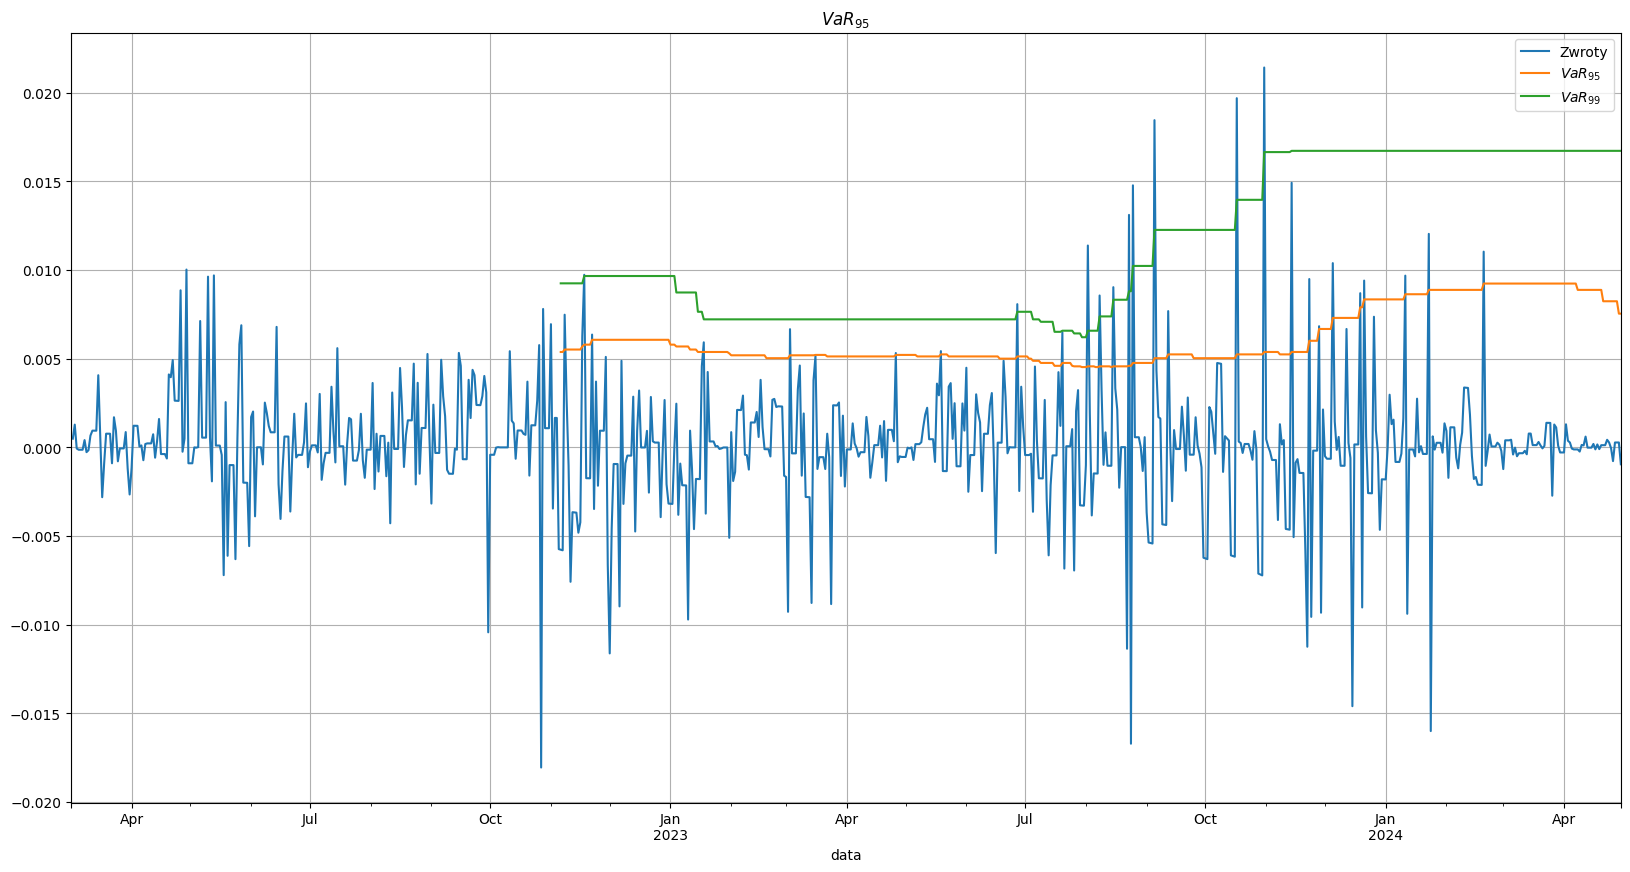

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist', 'var99_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{99}$'])
plt.savefig(f"pics\\{params['name']}\\var95.png")

Wykres cen i VaR95 dla cen.

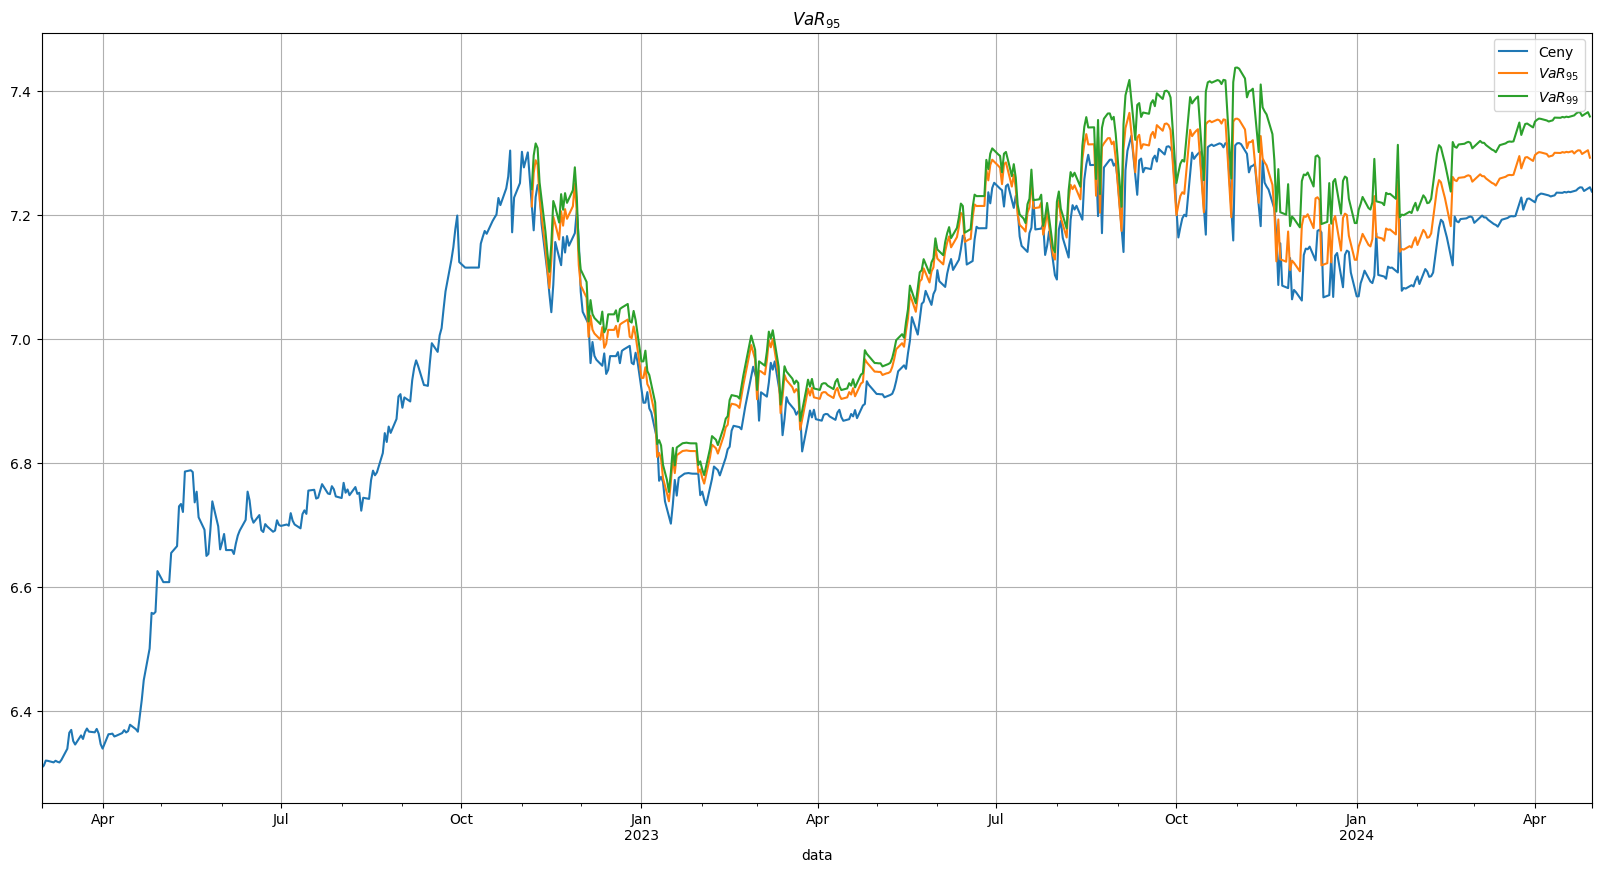

In [9]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['Close', 'VaR95_hist', 'VaR99_hist']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$')
plt.legend(['Ceny', '$VaR_{95}$', '$VaR_{99}$'])
plt.savefig(f"pics\\{params['name']}\\var95_ceny.png")

In [10]:
data, I95 = exceeds_vector(data, 'hist')  # I - wektor przekroczeń
data, I99 = exceeds_vector(data, 'hist', alpha99)

Wykres procentu przekroczeń dla okien 50.

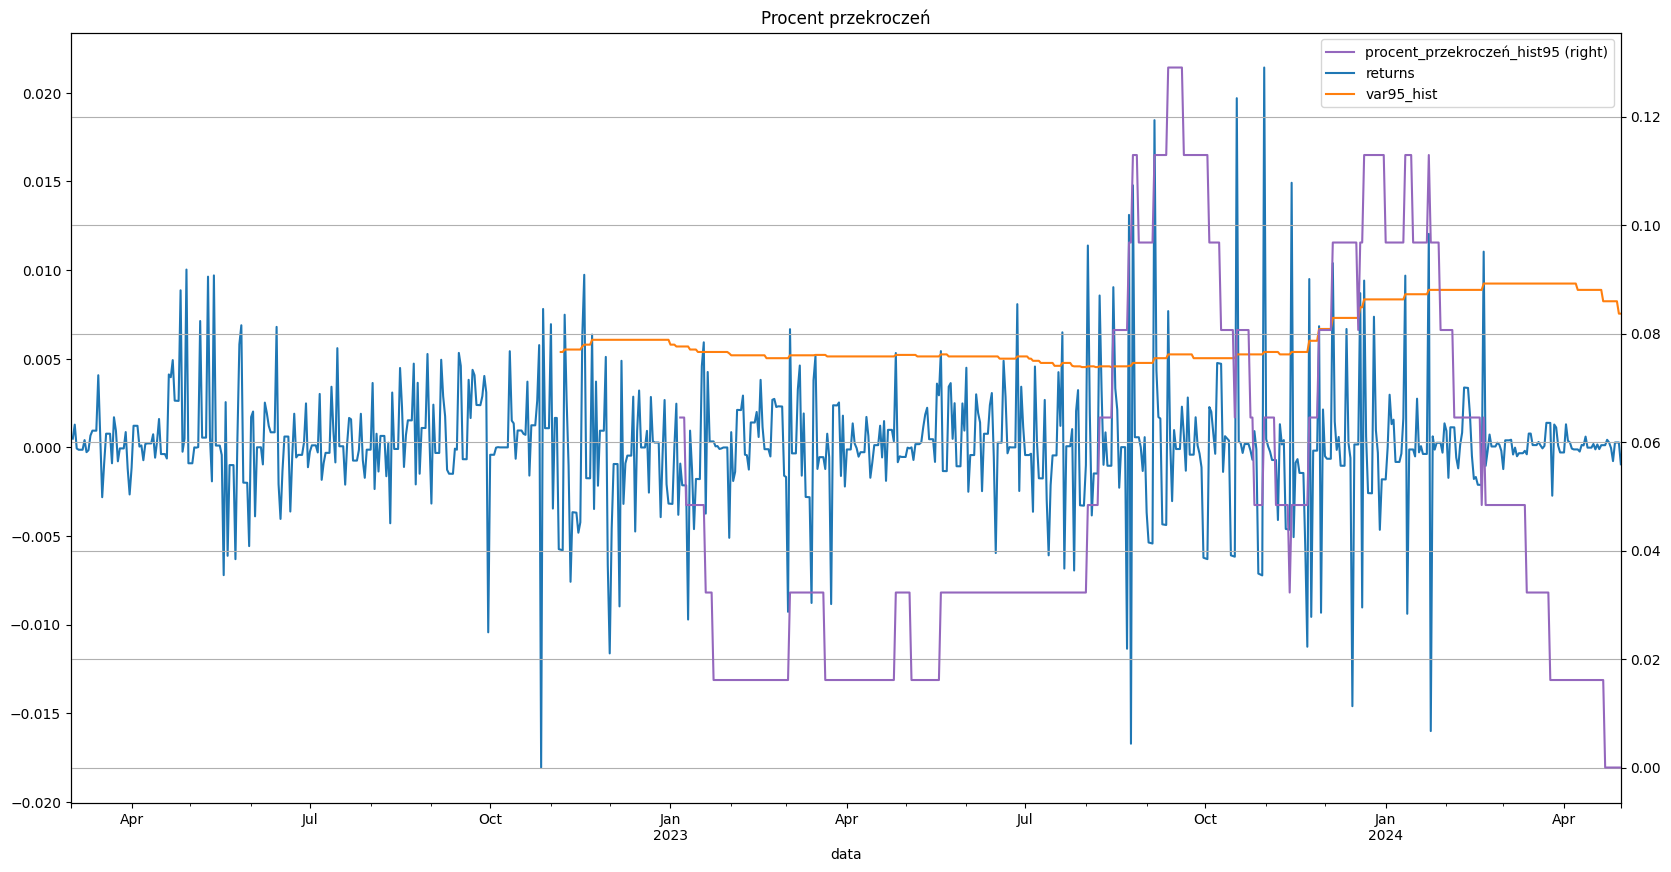

In [11]:
_, ax = plt.subplots(figsize=(20,10))
line1 = data[['procent_przekroczeń_hist95']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

_ = data[['returns', 'var95_hist']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C1'],
                                         xlabel='data',
                                         title='Procent przekroczeń', legend=True)
plt.savefig(f"pics\\{params['name']}\\procent-var95.png")

## Testowanie wsteczne

### Testy oparte o wektor przekroczeń

In [12]:
test_exceeds_vector(I95, .95)

,empiryczne,teoretyczne
średnia,0.051661,0.05
wariancja,0.049082,0.0475
binomtest p-wartość,0.843447,-
Kupiec - p-wartość,0.859933,-
christoffersen p-wartość,0.597969,-


In [13]:
test_exceeds_vector(I99, .99)

,empiryczne,teoretyczne
średnia,0.018450,0.01
wariancja,0.018143,0.0099
binomtest p-wartość,0.076742,-
Kupiec - p-wartość,0.076911,-
christoffersen p-wartość,0.519971,-


# Metoda ważonej symulacji historycznej

In [14]:
data = calculate_var(data, weighted_var, 'ważona')
data = calculate_var(data, lambda x, alpha: weighted_var(x, alpha95/100), 'ważona')
data = calculate_var(data, lambda x, alpha: weighted_var(x, alpha99/100), 'ważona', alpha=alpha99)

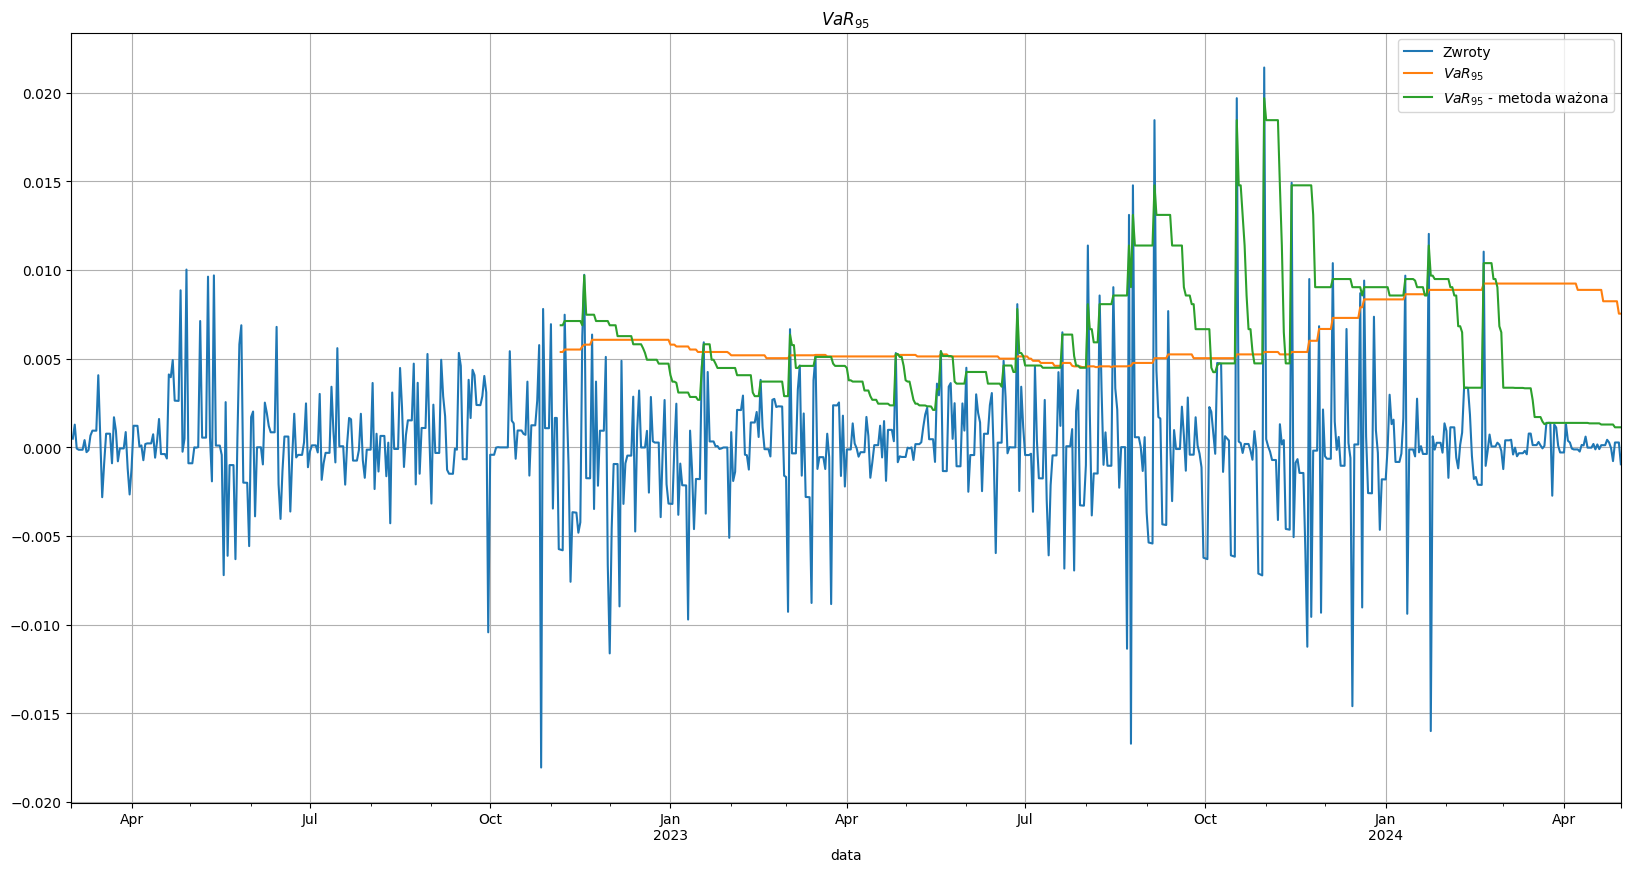

In [15]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_hist','var95_ważona']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$',
         color=['C0', 'C1', 'C2'])
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{95}$ - metoda ważona'])
plt.savefig(f'pics\\{params["name"]}\\var95_wazony.png')

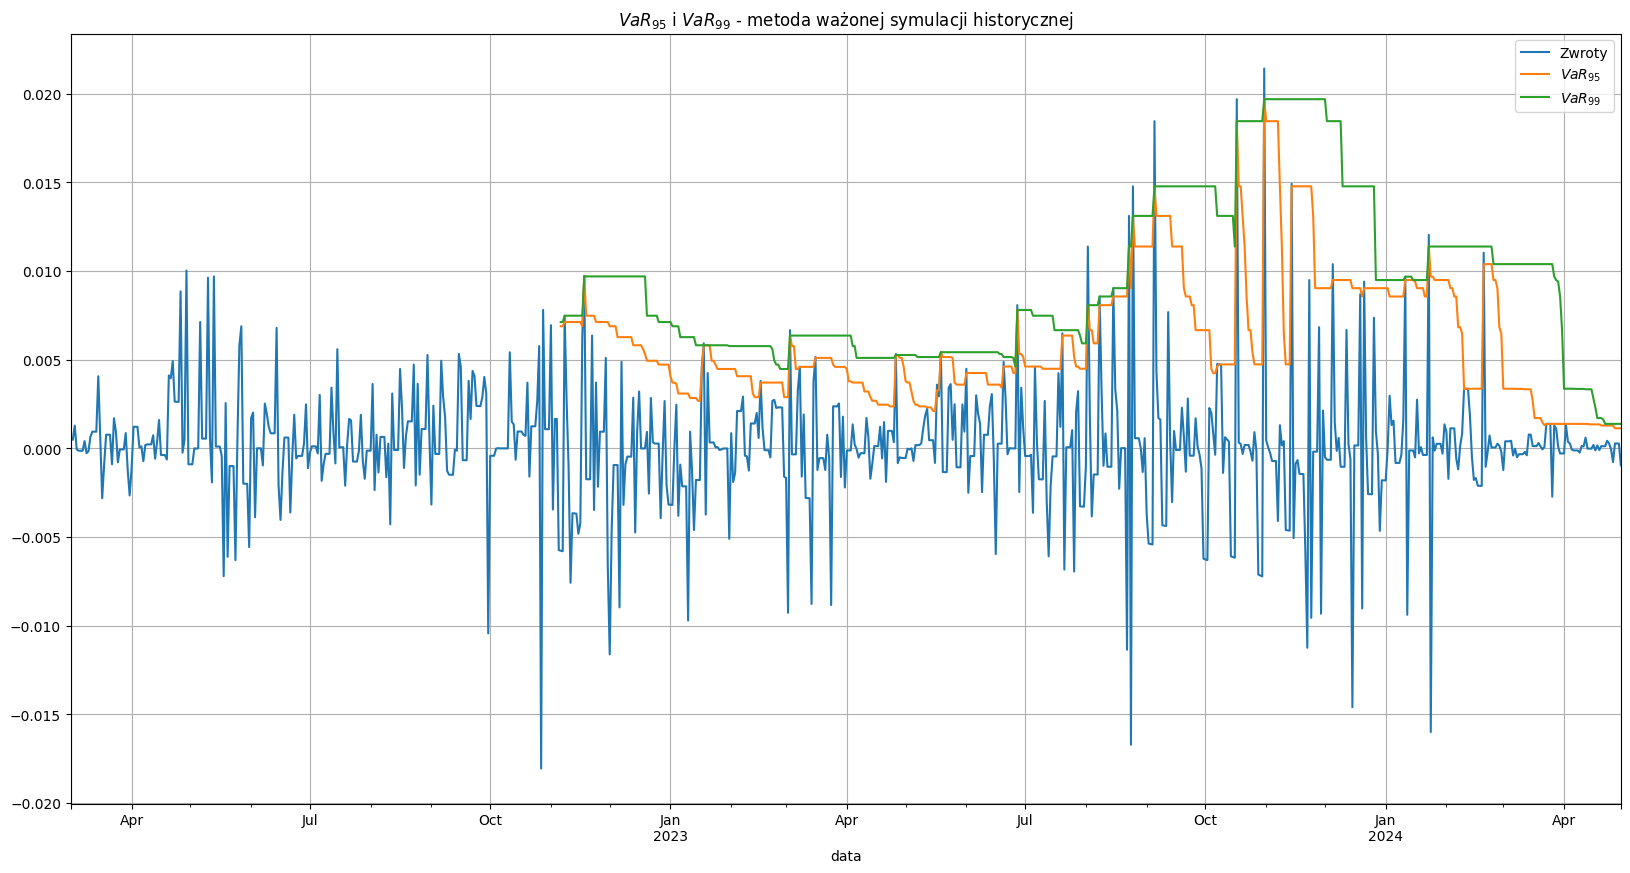

In [16]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_ważona','var99_ważona']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$ i $VaR_{99}$ - metoda ważonej symulacji historycznej',
         color=['C0', 'C1', 'C2'])
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{99}$'])
plt.savefig(f'pics\\{params["name"]}\\var95_99_wazony.png')

In [17]:
data, I95_weighted = exceeds_vector(data, 'ważona')
data, I99_weighted = exceeds_vector(data, 'ważona', alpha99)

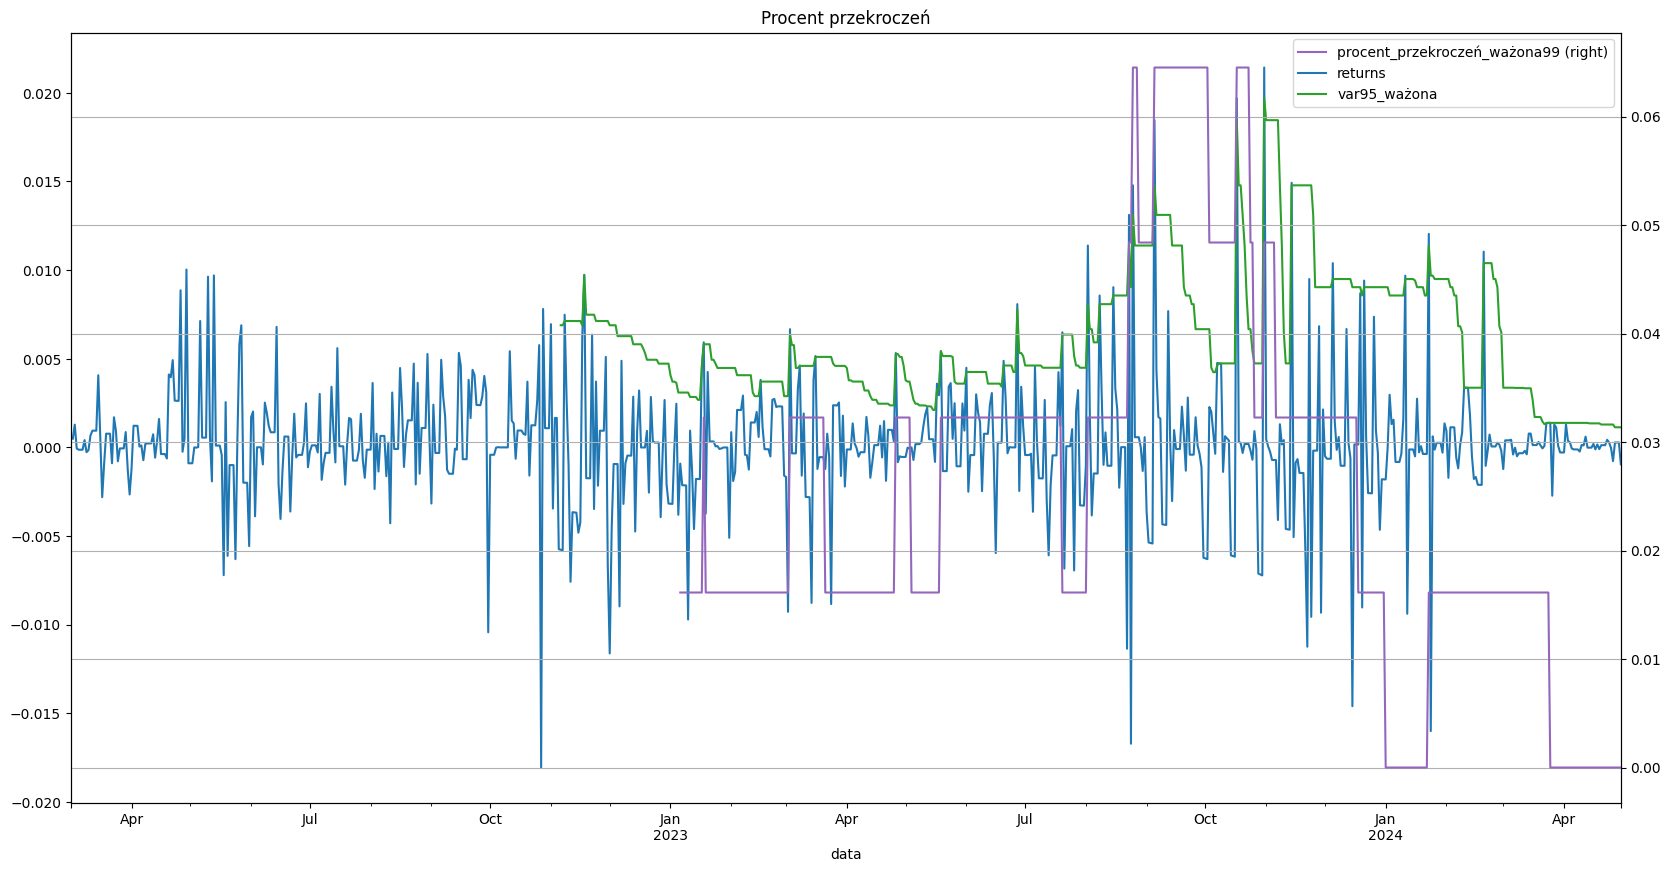

In [18]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['procent_przekroczeń_ważona99']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

_ = data[['returns', 'var95_ważona']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C2'],
                                         xlabel='data',
                                         title='Procent przekroczeń', legend=True)
plt.savefig(f"pics\\{params['name']}\\procent-var95-ważona.png")

## Testowanie wsteczne

### Rozkład dwumianowy

In [19]:
test_exceeds_vector(I95_weighted, .95)

,empiryczne,teoretyczne
średnia,0.059041,0.05
wariancja,0.055657,0.0475
binomtest p-wartość,0.323752,-
Kupiec - p-wartość,0.347185,-
christoffersen p-wartość,0.407733,-


In [20]:
test_exceeds_vector(I99_weighted, .99)

,empiryczne,teoretyczne
średnia,0.023985,0.01
wariancja,0.023453,0.0099
binomtest p-wartość,0.003759,-
Kupiec - p-wartość,0.005541,-
christoffersen p-wartość,0.406567,-


# Metoda filtrowanej symulacji historycznej

In [21]:
%%capture
data = calculate_var(data, lambda x, alpha: garch_var(x, alpha95/100), 'garch')
data = calculate_var(data, lambda x, alpha: garch_var(x, alpha99/100), 'garch', alpha=alpha99)

In [22]:
data, I95_garch = exceeds_vector(data, 'garch', 95)
data, I99_garch = exceeds_vector(data, 'garch', 99)

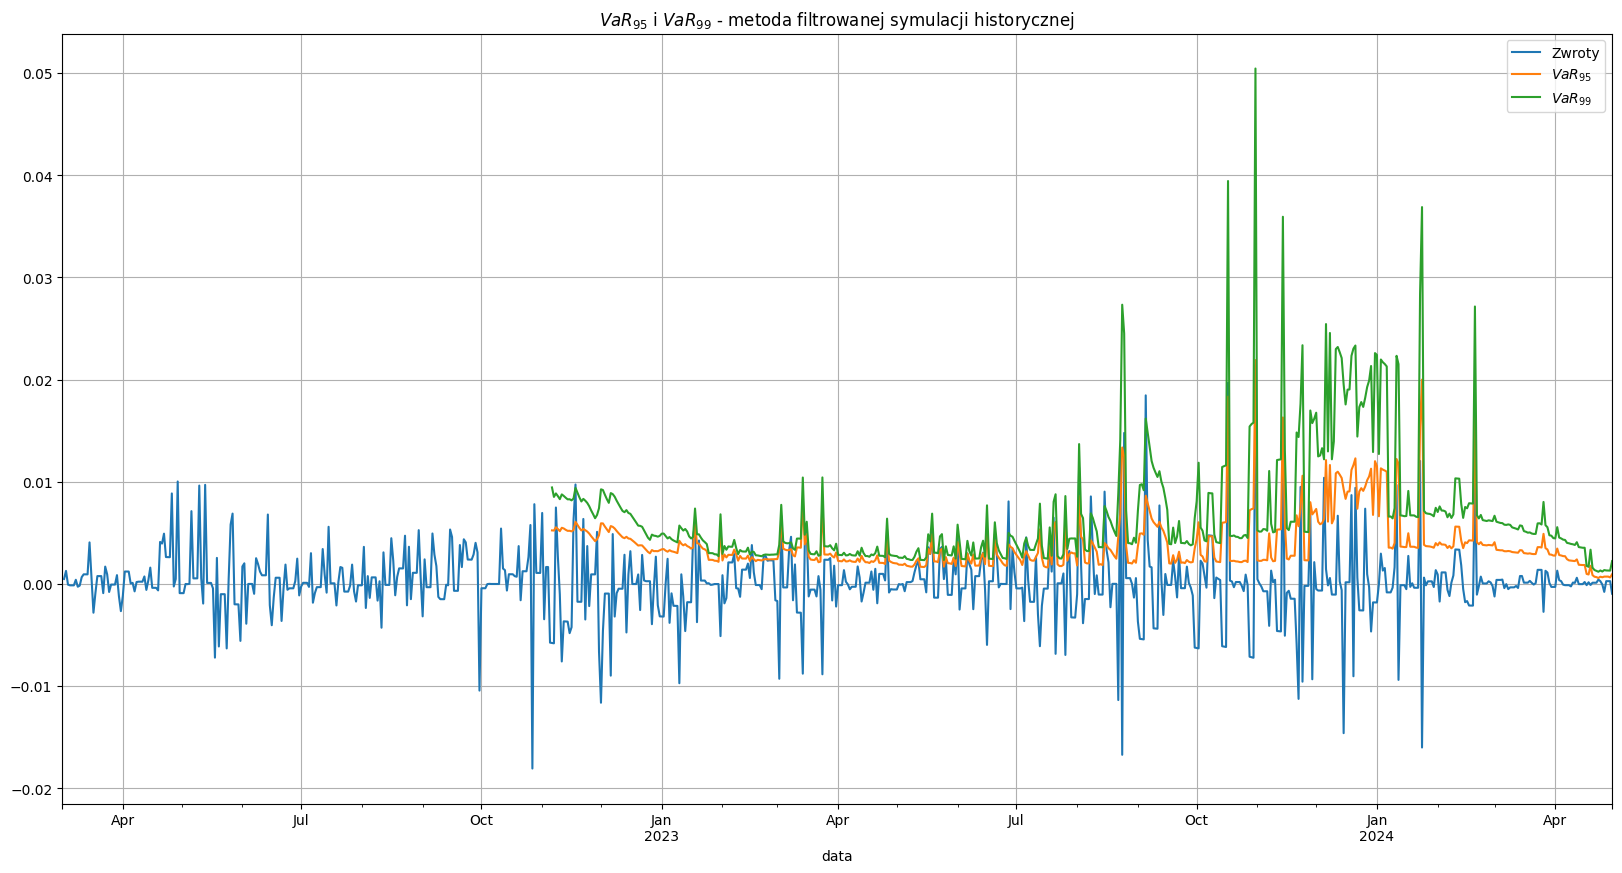

In [23]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['returns', 'var95_garch','var99_garch']].\
    plot(ax=ax,
         grid=True,
         xlabel='data',
         title='$VaR_{95}$ i $VaR_{99}$ - metoda filtrowanej symulacji historycznej',
         color=['C0', 'C1', 'C2'])
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{99}$'])
plt.savefig(f'pics\\{params["name"]}\\var95_99_garch.png')

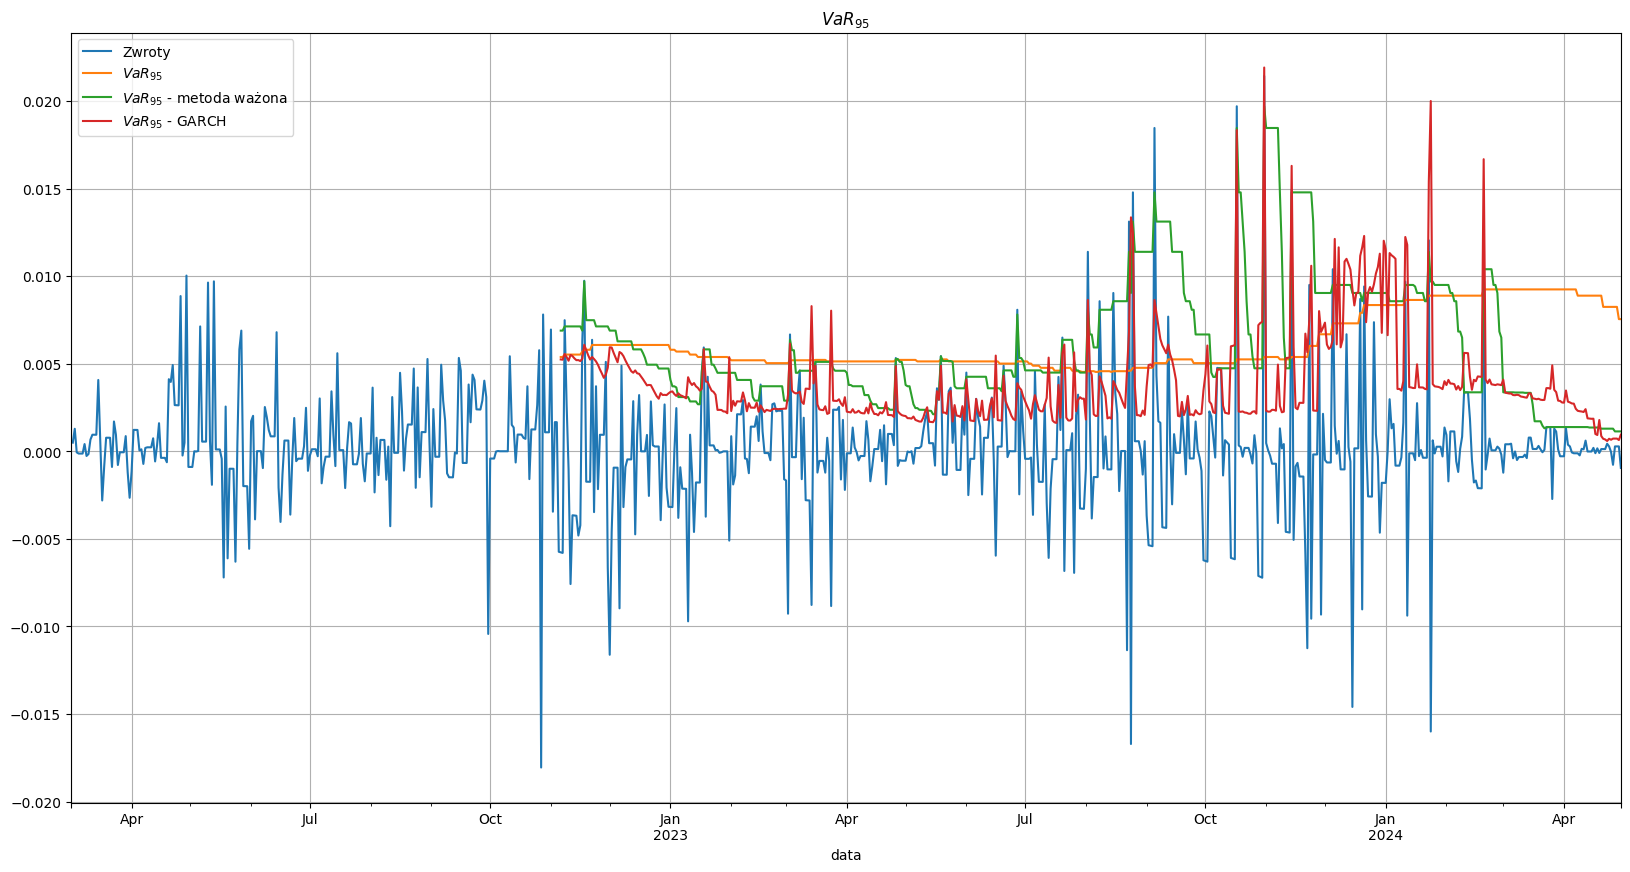

In [24]:
_, ax = plt.subplots(figsize=(20, 10))
_ = data[['returns', 'var95_hist', 'var95_ważona', 'var95_garch']].plot(ax=ax,
                                                                         grid=True,
                                                                         xlabel='data',
                                                                         title='$VaR_{95}$',
                                                                         color=['C0', 'C1', 'C2', 'C3'])
plt.legend(['Zwroty', '$VaR_{95}$', '$VaR_{95}$ - metoda ważona', '$VaR_{95}$ - GARCH'])
plt.savefig(f'pics\\{params["name"]}\\var95_garch.png')

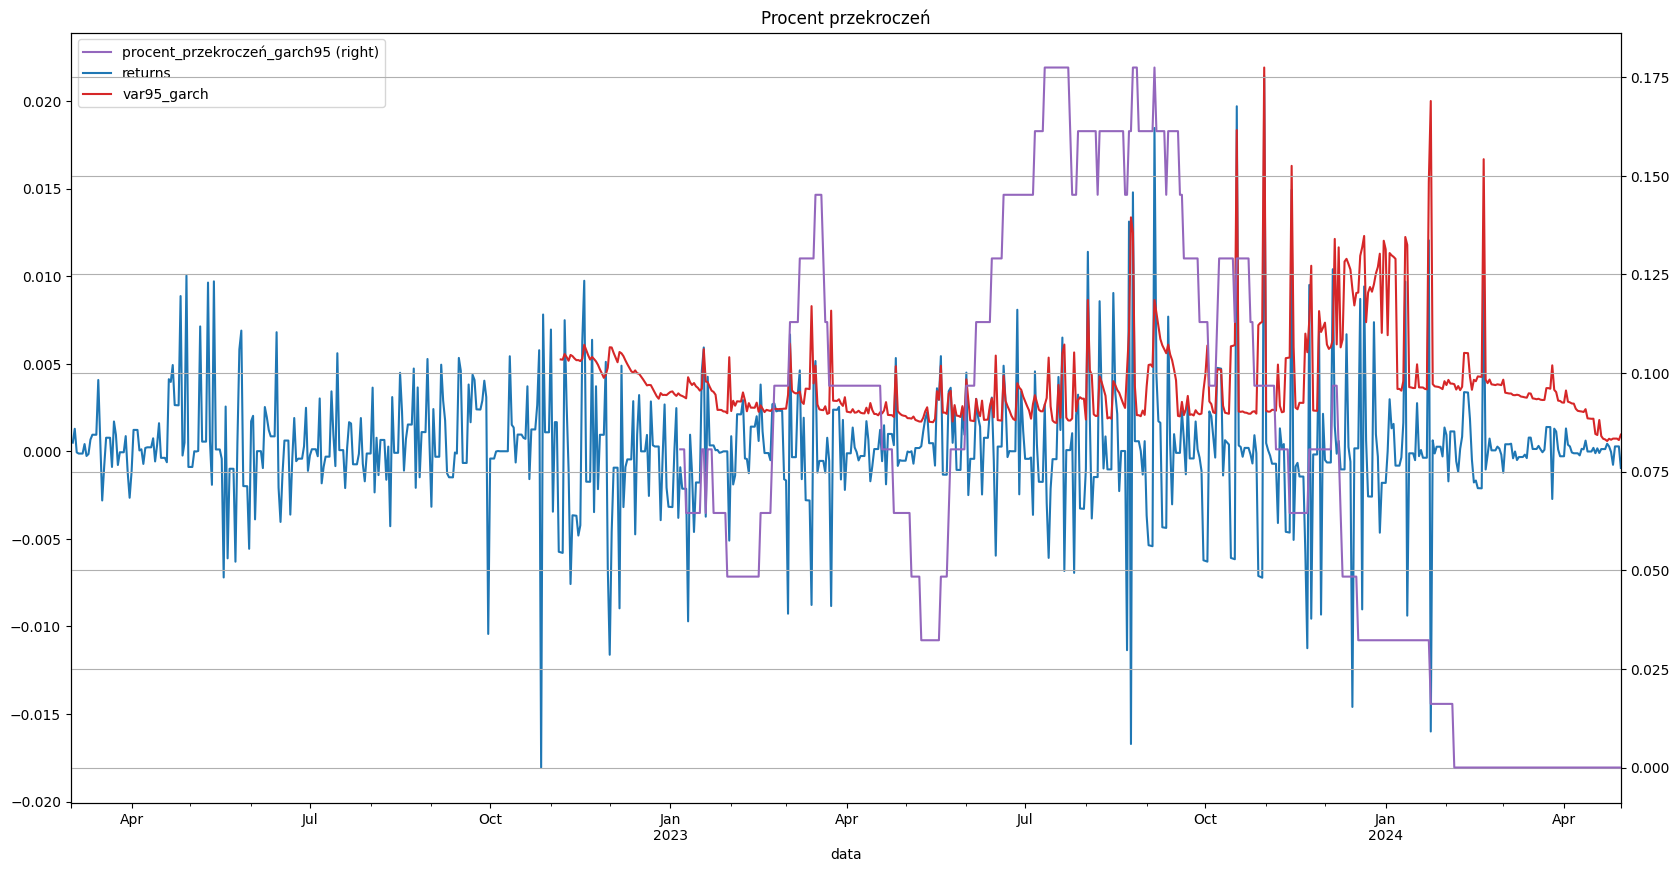

In [25]:
_, ax = plt.subplots(figsize=(20,10))
_ = data[['procent_przekroczeń_garch95']].plot(secondary_y=True,
                                            ax=ax,
                                            color='C4',
                                            legend=True)

_ = data[['returns', 'var95_garch']].plot(ax=ax,
                                         grid=True,
                                         style=['-', '-'],
                                         color=['C0', 'C3'],
                                         xlabel='data',
                                         title='Procent przekroczeń', legend=True)
plt.savefig(f"pics\\{params['name']}\\procent-var95-garch.png")

## Testowanie wsteczne

### Rozkład dwumianowy

In [26]:
test_exceeds_vector(I95_garch, .95)

,empiryczne,teoretyczne
średnia,0.077491,0.05
wariancja,0.071618,0.0475
binomtest p-wartość,0.005539,-
Kupiec - p-wartość,0.006383,-
christoffersen p-wartość,0.120258,-


In [27]:
test_exceeds_vector(I99_garch, .99)

,empiryczne,teoretyczne
średnia,0.014760,0.01
wariancja,0.014569,0.0099
binomtest p-wartość,0.272123,-
Kupiec - p-wartość,0.298260,-
christoffersen p-wartość,0.603381,-
